# Clasificador de Webpages con Python

Jose Manuel Coello

## Objetivo

Este proyecto consiste en trabajar procesamiento de texto implementando
técnicas incluidas en el procesamiento de lenguaje natural (NLP) y web
scraping para la extracción de los datos, seguido por un modelo de
clasificación de texto utilizando Python, como referencia guía usaré el
siguiente tutorial de
[DataCamp](https://www.datacamp.com/tutorial/text-classification-python).

## ¿Qué es la clasificación de texto?

Clasificación de texto es una tarea común en el NPL usado para resolver
problemas de negocios en varios campos, el objetivo de la clasificación
de texto es categorizar o predecir una clase de documentos de textos
desconocidos, frecuentemente con la ayuda del aprendizaje de máquina
supervizado. Moez All (Nov 2022)
[DataCamp](https://www.datacamp.com/tutorial/text-classification-python)

## Clasificación de webpages o urls.

En este caso entrenaremos un modelo de regresión logística sobre data
previamente procesada y categorizada, el conjunto de datos incluye tanto
el texto no procesado como su categoría, una vez el modelo es entrenado
es usado para obtener una categoría sobre nuevas urls o páginas web las
cuales no tenemos su categoría.

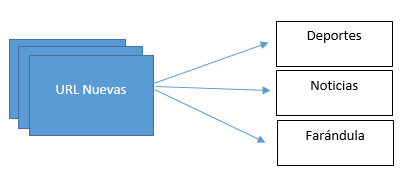

### Fase de entrenamiento.

El modelo de regresión logística es entrenado sobre registros de un
conjunto de datos categorizado durante la fase de entrenamiento. Al
final de este proceso obtenemos un modelo que usaremos para obtener
predicciones (clasificaciones) sobre registros desconocidos.

### Fase de predicción.

Como ya mencionamos, una vez que el modelo es entrenado, puede ser usado
para predecir categorías sobre nuevos registros, esto es usualmente
hecho una vez desarrollado el “mejor” modelo en la fase de
entrenamiento, el modelo debe ser validado a través de distintas
métricas de rendimiento, en este caso usaré solo la matriz de confusión.

## Pipeline para procesamiento de texto.

Procesamiento de texto es un importante paso en cualquier tarea de
procesamiento de lenguaje natural, un pipeline de procesamiento de texto
es una serie de pasos que son aplicados a datos de texto sin formato.
Los pasos en el procesamiento de texto pueden variar, sin embargo
típicamente incluyen tareas tales como tokenización, remover palabras
tales como conectores, entre otras (stop words) y lematización. Estos
pasos ayudan a reducir el tamaño de la data de texto y tambien mejoran
la exactitud en la clasificación.

La data de texto es difícil de procesar porque es no estructurada y
frecuentemente contiene mucho “ruido”. El ruido puede estar en forma de
errores gramaticales, un formato no estándar, entre otros. El pipeline
de procesamiento de texto esta enfocado a limpiar ese ruido así los
datos puede ser más facil de analizar.

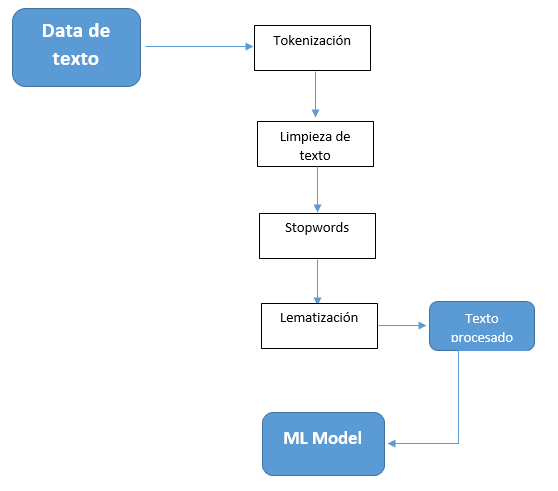

## Extracción de características

Un método común para la extracción de características de texto o en
otras palabras convertir la data de texto a campos numéricos así poder
entrenar un modelo de aprendizaje de máquina es conocida como Bag of
Words o CountVectorizer. El método de Bag of Words es una simple manera
de representar data de texto como campos numéricos. Consiste en crear un
vocabulario de palabras conocidas en el corpus y luego crear un vector
para cada texto que contiene el conteo de la frecuencia de cada palabra.

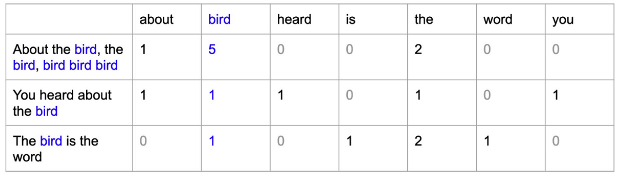

## Modelo de clasificación en Python

Para el proyecto se quiere elaborar un clasificador de paginas web, para
ello se hizo previamente la recolección de los datos donde diariamente
se recolectó las diez primeras búsquedas en Google de las consultas:
sports, news y entertainment, una vez obtenidos los resultados se
extrajo la siguiente información: url de la página, título de la página,
descripción de la página, posición de la búsqueda y categoría.

El objetivo es entrenar un modelo de regresión logística que aprenda del
texto del título, descripción y categoría de la página web para así
poder predecir la clase de nuevas páginas web.

Las siguientes líneas de código realizan el proceso de webscraping para
la obtención de los datos.

In [1]:
import urllib.request, urllib.parse, urllib.error, os
import csv
import ssl
from bs4 import BeautifulSoup
from googlesearch import search

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# urls to search
queries = ['sports', 'news', 'entertainment']
urls = []
for q in queries:
  count = 1
  for url in search(q, tld="com", lang='en', num=10, start=1, stop=10, pause=2):
    urls.append((url, count, q))
    count += 1

# get url, title and description
my_data = []
for url in urls:
  try:
    html = urllib.request.urlopen(url[0], context=ctx, timeout=10).read()
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.title.getText()
    des = soup.find_all('meta')
  except:
    continue
  for d in des:
    my_dict = d.attrs
    if my_dict.get('name', 'no') == 'description':
      my_data.append([url[1], url[0], title, my_dict.get('content'), url[2]])
      break

# check for urls that could not be read
for i in urls:
  if i[0] not in [k[1] for k in my_data]:
    print(i)

# write/append the data to the data.csv file
if not os.path.isfile("data.csv"):
  with open('data.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter = ';')
    writer.writerow(['position', 'url', 'title', 'description', 'tag'])
    writer.writerows(my_data)
else:
  with open('data.csv', 'a') as csvfile:
    writer = csv.writer(csvfile, delimiter = ';')
    writer.writerows(my_data)
    csvfile.close()

Una vez hecha la recolección de los datos procedemos a realizar la
lectura de los mismos.

In [2]:
# modules
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# read data
data = pd.read_csv('data.csv', sep = ';')

# view data structure
data.head()

Revisamos la dimensionalidad de los datos y vemos la distribución por
categorías.

In [3]:
# data dimensionality
data.shape

(223, 5)

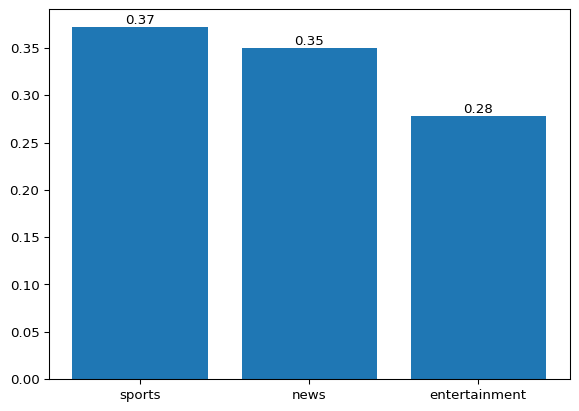

In [4]:
# general information
prop = list(data['tag'].value_counts(normalize = True))
tags = list(data['tag'].unique())
fig, ax = plt.subplots()
hbars = ax.bar(tags, prop, align='center')
ax.bar_label(hbars, fmt='%.2f')
plt.show()

### Procesamiento de texto

En esta fase se realizará toda la limpieza de datos que incluye
eliminación de caracteres especiales, estandarización del texto (todo el
texto en minúsculas), tokenización, eliminación de palabras no deseadas
(stopwords) y lematización.

Para ello almaceno tanto los títulos como las descripciones de las
páginas web en una lista, para luego pasar cada elemento de la lista de
texto por una función previamente definida que realice todo el proceso
anteriormente dicho y así obtener mi corpus.

In [5]:
# create a list text
fields = ('title', 'description')
text = [list(data[i]) for i in fields]

# preprocessing loop
nltk.download('all')
lemmatizer = WordNetLemmatizer()

def clean_data(string):
  r = re.sub('[^a-zA-Z]', ' ', string)
  r = r.lower()
  r = r.split()
  r = [word for word in r if word not in stopwords.words('english')]
  r = [lemmatizer.lemmatize(word) for word in r]
  r = ' '.join(r)
  return r

corpus = list(map(lambda lst: list(map(clean_data, lst)), text))

In [6]:
# view of the first five web page titles cleaned
corpus[0][:5]

['yahoo sport news score video fantasy game schedule yahoo sport',
 'espn serving sport fan anytime anywhere',
 'cbs sport news live score schedule fantasy game video cbssports com',
 'sport news score prediction analysis usa today',
 'nbc sport news score stats rumor video']

In [7]:
# view of the first five web page descriptions cleaned
corpus[1][:5]

['sport news score fantasy game',
 'visit espn live score highlight sport news stream exclusive game espn play fantasy sport',
 'cbs sport feature live scoring news stats player info nfl football mlb baseball nba basketball nhl hockey college basketball football',
 'usa today provides latest sport news score schedule stats odds nfl mlb nba nhl college sport',
 'stay date latest sport news score nbc sport']

Una vez obtenido el texto ya “limpio” procedo a fusionar el texto de los
títulos y las descripciones de las páginas web en un solo campo y para
luego ser anexado a la data.

In [8]:
# merge title and description into one field
title_des = [' '.join(i) for i in zip(corpus[0], corpus[1])]
data = data.assign(text = title_des)

# assign corpus to data
for i in range(len(fields)):
  data[fields[i]] = corpus[i]

data.head()

Procedemos a separar el dataset en datos de entrenamiento y datos de
prueba, en este caso trabajaré con un 70% de los datos para entrenar el
modelo y un 30% para probar el modelo.

In [9]:
# train-test-split
x = data['text']
y = data['tag']
# train test split (70% train - 30% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)

Luego, se procede a implementar el modelo de “Bag of Words”
(CountVectorizer) para convertir el texto ya limpio en campos numéricos.
Esto es necesario para el entrenamiento del modelo.

In [10]:
cv = CountVectorizer()
x_train_cv = cv.fit_transform(x_train)
print(x_train_cv.toarray())

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

In [11]:
x_train_cv.shape

(156, 218)

### Entrenamiento del modelo y evaluación

En esta parte se entrenará un modelo de regresión logística y
evaluaremos la matriz de confusión del modelo utilizando los datos de
prueba

In [12]:
# training Logistic Regression model
lr = LogisticRegression()
lr.fit(x_train_cv, y_train)

# transform x_test using CV
x_test_cv = cv.transform(x_test)

# generate predictions
predictions = lr.predict(x_test_cv)
predictions

array(['sports', 'news', 'entertainment', 'entertainment', 'sports',
       'entertainment', 'sports', 'news', 'sports', 'entertainment',
       'entertainment', 'entertainment', 'entertainment', 'entertainment',
       'news', 'sports', 'news', 'sports', 'entertainment', 'sports',
       'sports', 'sports', 'entertainment', 'sports', 'sports',
       'entertainment', 'entertainment', 'entertainment', 'sports',
       'sports', 'sports', 'news', 'entertainment', 'entertainment',
       'news', 'sports', 'news', 'sports', 'news', 'news',
       'entertainment', 'news', 'sports', 'news', 'sports', 'news',
       'sports', 'entertainment', 'news', 'sports', 'entertainment',
       'entertainment', 'news', 'news', 'news', 'entertainment',
       'entertainment', 'news', 'sports', 'news', 'entertainment',
       'entertainment', 'news', 'sports', 'sports', 'news', 'news'],
      dtype=object)

In [13]:
# confusion matrix
cm = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), 
                  index=['entertainment','news', 'sports'], 
                  columns=['entertainment','news', 'sports'])
cm

## Predicción de posiciones de urls por categoría

Para finalizar con el proyecto se procedera a predecir las posiciones de
las url para cada una de sus categorías.

Ejemplo, supongamos que durante cinco días consecutivos se toman las
primeras diez urls de Google de las búsquedas Sports, News y
Entertainment, para la búsqueda Sports se tiene la url www.ESPN.com con
los siguientes registros:

| Día | Posición | URL          | Categoría |
|-----|----------|--------------|-----------|
| 1   | 1        | www.ESPN.com | Sports    |
| 2   | 2        | www.ESPN.com | Sports    |
| 3   | 1        | www.ESPN.com | Sports    |
| 4   | 1        | www.ESPN.com | Sports    |
| 5   | 2        | www.ESPN.com | Sports    |
| 6   | **?**    | www.ESPN.com | Sports    |

Con base en los siguientes registros nos gustaría saber qué posición
ocupará la url www.ESPN.com al día siguiente. Para ello volvemos a
entrenar un modelo de regresión para cada una de las categorías, pero en
esta ocasión los datos de entrenamiento y prueba no se dividirán
aleatoriamente, sino que trabajaremos con los datos recopilados antes
del último web scraping, con esos datos se entrenará el modelo, para
luego ser probado con los datos del último web scraping, de esta manera
saber cuantos registros fueron predichos correctamente.

In [14]:
# train a new model now with the position variable as response variable per tag
url_var = list(data['url'])
pos_var = list(data['position'])
tag_var = list(data['tag'])

# make a nested list where each element of the list will be a list with each record of the daily webscraping
daily_data = []
df = []
pos = pos_var[0]
n_tag = 0
for i in range(len(url_var)):
  if pos <= pos_var[i]:
    pos = pos_var[i]
    df.append([url_var[i], str(pos_var[i]), tag_var[i]])
  else:
    n_tag += 1
    pos = pos_var[i]
    if n_tag < 3:
      df.append([url_var[i], str(pos_var[i]), tag_var[i]])
    
  if n_tag == 3:
    n_tag = 0
    daily_data.append(df)
    df = []
    df.append([url_var[i], str(pos_var[i]), tag_var[i]])
  
  if i == len(url_var) - 1:
    daily_data.append(df)
    
# get train data sets and test data sets by tag 
x_train_sport, y_train_sport, x_train_news, y_train_news, x_train_enter, y_train_enter = [],[],[],[],[],[]
x_test_sport, y_test_sport, x_test_news, y_test_news, x_test_enter, y_test_enter = [],[],[],[],[],[]

# train data set
for day in daily_data[:len(daily_data)-1]:
  for row in day:
    if row[2] == 'sports':
      x_train_sport.append(row[0])
      y_train_sport.append(row[1])
    elif row[2] == 'news':
      x_train_news.append(row[0])
      y_train_news.append(row[1])
    else:
      x_train_enter.append(row[0])
      y_train_enter.append(row[1])

# test data set
for row in daily_data[-1]:
  if row[2] == 'sports':
    x_test_sport.append(row[0])
    y_test_sport.append(row[1])
  elif row[2] == 'news':
    x_test_news.append(row[0])
    y_test_news.append(row[1])
  else:
    x_test_enter.append(row[0])
    y_test_enter.append(row[1])
      
# function to train the model 
def models(x_train, y_train, x_test, y_test):
  x_train_cv = cv.fit_transform(x_train)
  # training Logistic Regression model
  lr = LogisticRegression()
  lr.fit(x_train_cv, y_train)
  # transform x_test using CV
  x_test_cv = cv.transform(x_test)
  # generate predictions
  predictions = lr.predict(x_test_cv)
  # confusion matrix
  cm = pd.DataFrame(metrics.confusion_matrix(y_test, predictions))
                     
  print('records:', len(y_test))
  return cm

# result
x_train = [x_train_sport, x_train_news, x_train_enter]
y_train = [y_train_sport, y_train_news, y_train_enter]
x_test = [x_test_sport, x_test_news, x_test_enter]
y_test = [y_test_sport, y_test_news, y_test_enter]
tag = ['Sport', 'News', 'Entertainment']

for idx in range(len(tag)):
  print(tag[idx])
  print(models(x_train=x_train[idx], y_train=y_train[idx], x_test=x_test[idx], y_test=y_test[idx]))
  print('')

Sport
records: 8
   0  1  2  3  4  5  6  7  8
0  1  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  1
2  0  0  0  1  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  1  0
5  0  0  0  0  0  0  1  0  0
6  0  0  0  0  0  1  0  0  0
7  0  0  0  0  0  0  0  1  0
8  0  1  0  0  0  0  0  0  0

News
records: 9
   0  1  2  3  4  5  6  7  8
0  1  0  0  0  0  0  0  0  0
1  0  0  1  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0
3  0  0  0  1  0  0  0  0  0
4  0  0  0  0  0  1  0  0  0
5  0  0  0  0  0  0  1  0  0
6  0  0  0  0  0  0  0  1  0
7  0  0  0  0  1  0  0  0  0
8  0  0  0  0  0  0  0  0  1

Entertainment
records: 7
   0  1  2  3  4  5  6  7
0  1  0  0  0  0  0  0  0
1  0  0  0  1  0  0  0  0
2  0  0  1  0  0  0  0  0
3  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0
5  0  0  0  0  0  1  0  0
6  0  0  0  0  0  0  0  1
7  0  0  0  0  1  0  0  0


## Conclusión

La clasificación de texto es una tarea ampliamente implementada en el
procesamiento del lenguaje natural, ya sea para clasificar o predecir
una clase. Existen diferentes algoritmos para configurar un clasificador
de texto, es importante experimentar para encontrar el “mejor” modelo
dependiendo de nuestro propósito.